<h1 style="text-align:center">Optimized Neural Network Tuning and Visualization for MNIST Digit Recognition: Enhancing Machine Learning Performance through Cluster Computing and Advanced Analysis Techniques</font></h1>  
<h2 style="text-align:center">Sai Sanwariya Narayan</h2>  

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Download the MNIST dataset using scikit-learn - this cell takes time - you don't need to run it everytime
mnist = fetch_openml("mnist_784")
data, target = mnist.data, mnist.target
X = data.values.astype('float32')
Y = target.values.to_numpy().astype('int32')
data = np.concatenate((X,Y.reshape(-1,1)),axis=-1).astype('int32')
# Save the NumPy array to a CSV file
np.savetxt('MNIST.csv', data, delimiter=',')

In [3]:
# Import necessary PySpark modules
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create a Spark session
spark = SparkSession.builder.appName("ClassificationExample").getOrCreate()

# Load your dataset (replace 'your_data.csv' with the actual data file)
data = spark.read.csv("MNIST.csv", header=False, inferSchema=True)

In [4]:
input_columns = data.columns[:-1]
output_columns = data.columns[-1]

# Create a feature vector by combining all feature columns into a single 'features' column
assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
data = assembler.transform(data)

In [5]:
# Scale the feature vector using StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

In [6]:
# Split the data into training and testing sets
(training_data, test_data) = data.randomSplit([0.8, 0.2], seed=123)

# Define the neural network architecture
layers = [len(input_columns), 16, 8, 10]  # Input, hidden, and output layer sizes

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, 
                                         layers=layers, 
                                         featuresCol='scaled_features',
                                         labelCol=output_columns, blockSize=128, seed=1234)

In [7]:
# Train the model on the training data
model = trainer.fit(training_data)

# Make predictions on the test data
predictions = model.transform(test_data)

In [8]:
evaluator = MulticlassClassificationEvaluator(labelCol=output_columns,predictionCol='prediction',metricName='f1')
ann_f1 = evaluator.evaluate(predictions)
ann_f1

0.916986136911825

In [9]:
# save model
model.save('/storage/home/Trained_Classifier')

## Implementing hyperparameter runing for the number of neurons in `layers` and the blockSize inside `trainer` below this line. Save the best model to disk with path name `./Best_Classifier`

In [10]:
# Define the range of neurons and block sizes
neurons_range = [10, 20, 30]
block_sizes = [64, 128, 256]

best_f1 = 0.0
best_model = None
best_params = {'neurons': None, 'block_size': None}

for neurons in neurons_range:
    for block_size in block_sizes:
        # Define the new layers with the varying number of neurons
        layers = [len(input_columns), neurons, neurons, 10]  # Adjust the hidden layers' neurons

        # Create a new trainer with the updated parameters
        trainer = MultilayerPerceptronClassifier(maxIter=100, 
                                                 layers=layers, 
                                                 featuresCol='scaled_features',
                                                 labelCol=output_columns, 
                                                 blockSize=block_size, 
                                                 seed=1234)

        # Train the model
        model = trainer.fit(training_data)

        # Evaluate the model
        predictions = model.transform(test_data)
        f1_score = evaluator.evaluate(predictions)

        # Update the best model if the current model is better
        if f1_score > best_f1:
            best_f1 = f1_score
            best_model = model
            best_params['neurons'] = neurons
            best_params['block_size'] = block_size

# Save the best model
if best_model:
    best_model.save('/storage/home/Best_Classifier')
    print(f"Best Model Saved with neurons: {best_params['neurons']} and block size: {best_params['block_size']}. F1 Score: {best_f1}")
else:
    print("No model improvement found.")


Best Model Saved with neurons: 30 and block size: 64. F1 Score: 0.9416088061725274


## Implement a matplotlib based visualization of classifier predictions and the corresponding images below this line (you do not have to do this for cluster mode)

In [15]:
## Load hyperparameter tuned model
model.load('./Best_Classifier')
# Make predictions on the test data with this better model
predictions = model.transform(test_data)

In [16]:
test_data_ip_np = predictions.select(input_columns).toPandas().values
test_data_op_np = predictions.select(output_columns).toPandas().values
test_data_pred_np = predictions.select('prediction').toPandas().values

In [17]:
print(test_data_ip_np.shape)
print(test_data_op_np.shape)
print(test_data_pred_np.shape)

(13906, 784)
(13906, 1)
(13906, 1)


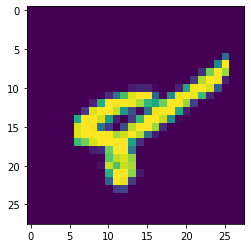

Predicted label: 8.0
True label: 8.0


In [18]:
idx = 7000 # this can be some integer between 0 and 13905 - feel free to try different things
plt.imshow(test_data_ip_np[idx,:].reshape(28,28))
plt.show()

print('Predicted label:',test_data_pred_np[idx,0])
print('True label:',test_data_op_np[idx,0])